# Table of Contents
* [Description](#Description)
* [Import Python Modules](#Import-Python-Modules)
* [Import Images](#Import-Images)
* [Experiment Input](#Experiment-Input)
	* [Distance Source-Detector ?](#Distance-Source-Detector-?)
	* [Detector Offset ?](#Detector-Offset-?)
	* [Select Which Bragg Edges Element you Want to See or Skip to Save Settings ?](#Select-Which-Bragg-Edges-Element-you-Want-to-See-or-Skip-to-Save-Settings-?)
		* [Select Spectra File](#Select-Spectra-File)
		* [Pick how you Want to Define your Element](#Pick-how-you-Want-to-Define-your-Element)
		* [Validate Choice](#Validate-Choice)
		* [Calculate Bragg Edges](#Calculate-Bragg-Edges)
	* [Save Settings](#Save-Settings)
* [Display Images and Make ROI Selection](#Display-Images-and-Make-ROI-Selection)
* [Display Total Counts vs File Index](#Display-Total-Counts-vs-File-Index)


# Description

In this notebook, you will be able to select a ROI on any of the image binned (see step6_rebinnned_files notebook). Then an average number of counts of this ROI vs file_index, or TOF, or lambda, will be displayed for all the rebinned files. 

# Import Python Modules 

In [1]:
verbose = False

try:
    from PyQt4.QtGui import QFileDialog
    from PyQt4 import QtCore, QtGui
except ImportError:
    from PyQt5.QtWidgets import QFileDialog
    from PyQt5 import QtCore, QtGui
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.core.display import display, HTML

from pprint import pprint
import pyfits

import sys
import datetime
import os
import glob
import shutil
import re

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from IPython.display import display
from IPython import display as display_ipython

if os.sys.platform == 'darwin':
    sys.path.append('/Users/j35/git/BraggEdge/python')
else:
    sys.path.append(r"C:\Users\user\Documents\GitHub\BraggEdge\python")
    sys.path.append(r"C:\Users\user\Anaconda3\envs\SNAP2016\lib\site-packages")
 
from neutronbraggedge.experiment_handler import *
from neutronbraggedge.braggedge import BraggEdge
from neutronbraggedge.material_handler.retrieve_material_metadata import RetrieveMaterialMetadata

import config_handler
import file_handler
import math_handler
import utilities

In [2]:
%gui qt

# Import Images 

In [3]:
input_folder = os.path.join(config_handler.load_config(key='output_folder'),'normalized')
list_bins = glob.glob(input_folder + '/bin#*')

In [4]:
#import images
w = widgets.IntProgress()
w.max = len(list_bins)
display(w)

data_array = []  #[nbr_bin, nbr_files, height, width]
for _index, _bin in enumerate(list_bins):
    _images_from_bin_name = glob.glob(_bin + '/*.fits')
    _images_from_bin_array = file_handler.read_fits(_images_from_bin_name)
    data_array.append(_images_from_bin_array)
    
    w.value = _index+1

[nbr_bin, nbr_files, width, height] = np.shape(data_array)

#import T vs bin_index file
output_folder = config_handler.load_config(key = 'output_folder')
file_name = os.path.join(output_folder, 'binning_list_of_files.csv')

df = pd.read_csv(file_name, index_col=0, header=None)
list_temperature_for_each_bin = []
for _temp in df.loc['temperature',:]:
    list_temperature_for_each_bin.append(_temp)

# Experiment Input 

## Distance Source-Detector ?

In [5]:
distance_source_detector = config_handler.load_config(key='distance_source_detector')
distance_source_detector_widget = widgets.Text(
    description = 'dSD (m)',
    value = str(distance_source_detector))
display(distance_source_detector_widget)

## Detector Offset ?

In [6]:
detector_offset = config_handler.load_config(key='detector_offset')
if detector_offset == '':
    detector_offset = '14'
detector_offset_widget = widgets.Text(
    description = 'detector_offset (micros)',
    value = str(detector_offset))
display(detector_offset_widget)

## Select Which Bragg Edges Element you Want to See or Skip to Save Settings ?  

You can either *select an element for a predefined list* (**choice 1**) or *define your own* (**choice 2**)

### Select Spectra File

In [7]:
lambda_array = []
tof_array = []

if not 'spectra_file' in locals():
    spectra_file = config_handler.load_config(key='spectra_file')

if (spectra_file == '') or (spectra_file == []):
    if 'input_folder' in locals():
        spectra_file_path = input_folder
    else:
        spectra_file_path = './'
else:
    spectra_file_path = os.path.dirname(spectra_file)
    spectra_file_path = './'

spectra_file = QtGui.QFileDialog.getOpenFileNames(None,
                                                  'Select _Spectra.txt file',
                                                  directory=spectra_file_path, 
                                                  filter= "ascii (*.txt)")

if spectra_file:
    spectra_file = spectra_file[0]
    try:
        _tof_handler = TOF(filename= spectra_file)
        _exp = Experiment(tof = _tof_handler.tof_array,
                     distance_source_detector_m = float(distance_source_detector_widget.value),
                     detector_offset_micros = float(detector_offset_widget.value))

        lambda_array = _exp.lambda_array
        tof_array = _exp.tof_array

    except IndexError:
        print("Please select another spectra file!")

### Pick how you Want to Define your Element 

In [8]:
select_element_choice = config_handler.load_config(key='select_element_choice')
list_of_choices = ['Select an Element from a List', 'Define your Own Element']
if select_element_choice == '':
    select_element_choice = list_of_choices[0]
select_element_choice_widget = widgets.Dropdown(options=list_of_choices,
                                               value=select_element_choice,
                                               description='Make a Choice')
display(select_element_choice_widget)

### Validate Choice

In [9]:
if select_element_choice_widget.value == list_of_choices[0]:
    display(HTML('<span style="font-size: 20px">Select an Element from the List</span>'))
    retrieve_material = RetrieveMaterialMetadata(material = 'all')
    list_returned = retrieve_material.full_list_material()
    element_name = config_handler.load_config(key='element_name')
    if element_name == '':
        element_name = list_returned[0]
    element_selected = widgets.Dropdown(options=list(list_returned),
                                        value=element_name,
                                       description='Select an Element')
    display(element_selected)
else:
    display(HTML('<span style="font-size: 20px">Define your own Element (name, lattice, crystal structure)</span>'))
        
    custom_element_name = config_handler.load_config(key='custom_element_name')
    element_name_widget = widgets.Text(description='Custome Element Name:', value=str(custom_element_name))
    display(element_name_widget)

    custom_lattice_value = config_handler.load_config(key='custom_lattice_value')
    if custom_lattice_value == '':
        custom_lattice_value = '1'
    lattice_value_widget = widgets.Text(description=u'Lattice (\u212B):', value=custom_lattice_value)
    display(lattice_value_widget)

    custom_crystal_structure = config_handler.load_config(key='custom_crystal_structure')
    if custom_crystal_structure == '':
        custom_crystal_structure = 'FCC'
    crystal_structure_widget = widgets.Dropdown(options=['FCC','BCC'],
                                        description='Select a Crystal Structure',
                                        value=custom_crystal_structure)
    display(crystal_structure_widget)

### Calculate Bragg Edges 

In [10]:
if select_element_choice_widget.value == list_of_choices[0]:
    element = element_selected.value
    _handler = BraggEdge(material=[element])
else:
    element = element_name_widget.value
    _lattice = lattice_value_widget.value
    _crystal = crystal_structure_widget.value
    _handler = BraggEdge(new_material=[{'name':element,
                                      'lattice': float(_lattice),
                                      'crystal_structure': _crystal}])
bragg_edges = _handler.bragg_edges
hkl = _handler.hkl

_hkl_formated = []
for _hkl in hkl[element]:
    _hkl_s = ",".join(str(x) for x in _hkl)
    _hkl_formated.append(_hkl_s)

## Save Settings

In [11]:
if 'distance_source_detector_widget' in locals():
    config_handler.save_config(key='distance_source_detector', value=distance_source_detector_widget.value)
if 'detector_offset_widget' in locals():
    config_handler.save_config(key='detector_offset', value=str(detector_offset_widget.value))
if 'element_selected' in locals():
    config_handler.save_config(key='element_name', value=element_selected.value)
if 'element_name_widget' in locals():
    config_handler.save_config(key='custom_element_name', value=element_name_widget.value)
if 'lattice_value_widget' in locals():
    config_handler.save_config(key='custom_lattice', value=lattice_value_widget.value)
if 'crystal_structure_widget' in locals():
    config_handler.save_config(key='custom_crystal_structure', value=crystal_structure_widget.value)

# Display Images and Make ROI Selection 

[4, 200, 180, 300, 100]

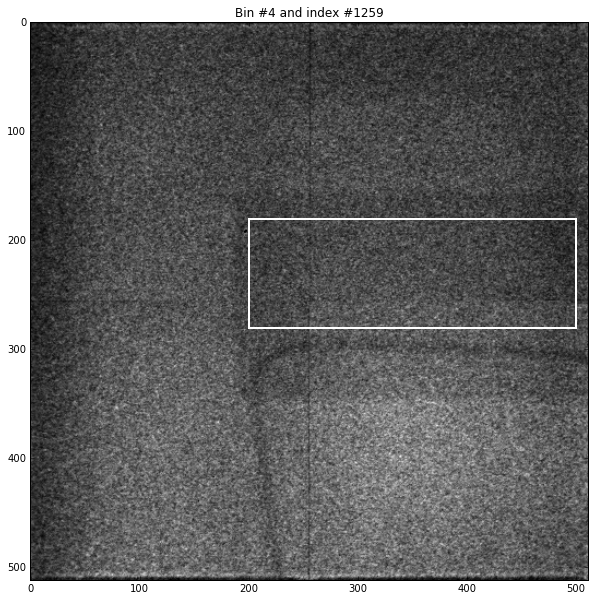

In [12]:
def plot_images(bin_index, file_index, x_left, y_top, width, height):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(data_array[bin_index][file_index],
                 cmap='gray')
    ax_img.set_title("Bin #{} and index #{}".format(bin_index, file_index))
    
    _rectangle = patches.Rectangle((x_left, y_top),
                                  width,
                                  height,
                                  edgecolor = 'white',
                                  linewidth = 2,
                                  fill = False)
    ax_img.add_patch(_rectangle)
    
    return [bin_index, x_left, y_top, width, height]
    
preview = interact(plot_images,
                  bin_index = widgets.IntSlider(min=0, 
                                                max=nbr_bin-1,
                                               step=1,
                                               value=0,
                                               description='Bin Index'),
                  file_index = widgets.IntSlider(min=0,
                                                max=nbr_files-1,
                                                step=1,
                                                value=0,
                                                description="File Index"),
                  x_left = widgets.IntSlider(min=0,
                                            max=width,
                                            step=1,
                                            value=1,
                                            description='X Left'),
                  y_top = widgets.IntSlider(min=0,
                                           max=height,
                                           value=1,
                                           step=1,
                                           description='Y Top'),
                  width = widgets.IntSlider(min=0,
                                           max=width,
                                           step=1,
                                           value=width-2,
                                           description="Width"),
                  height = widgets.IntSlider(min=0,
                                            max=height,
                                            step=1,
                                            value=height-2,
                                            description='Height'))

# Display Total Counts vs File Index, TOF, Lambda or Lambda + Bragg Edges

In [13]:
[bin_index, x_left, y_top, width, height] = preview.widget.result

x_right = x_left + width
y_bottom = y_top + height

list_bin_button = ["Bin#{}".format(_bin) for _bin in np.arange(nbr_bin)]
list_bin_T = ["{:04.1f}C".format(float(_T)) for _T in list_temperature_for_each_bin]
bin_pre_selected = ["Bin#{}".format(bin_index)]
bin_T_pre_selected = "{:04.1f}C".format(float(list_temperature_for_each_bin[bin_index]))

def get_T_bin_index(_T_bin):
    return list_bin_T.index(_T_bin)

def plot_1(list_of_T_to_plot, xaxis_type):
    """
    routine used when a lambda_array has been defined
    user will have the option to plot vs file_index, tof or lambda
    """
    
    global_sum_data = []
    data_to_plot = []
    for _bin_name in list_of_T_to_plot:
        _bin_index = get_T_bin_index(_bin_name)

        sum_cropped_data = []
        data = data_array[_bin_index]
        for _data in data[:]:
            _sum_data = np.sum(_data[y_top:y_bottom, x_left:x_right])
            sum_cropped_data.append(_sum_data)

        global_sum_data.append(sum_cropped_data)

        _bin_T = "{:04.1f}C".format(float(list_temperature_for_each_bin[_bin_index]))

        if xaxis_type == 'File Index':
            x_axis = np.arange(nbr_files)
            title = 'Sum Counts vs File Index'
        elif (xaxis_type == 'Lambda') or (xaxis_type == 'Lambda + Bragg Edges'):
            x_axis = lambda_array
            title = 'Sum Counts vs Lambda'
        else:
            x_axis = tof_array
            title = 'Sum Counts vs TOF'

        trace = go.Scatter(x=x_axis,
                           y=sum_cropped_data,
                           name=_bin_T,
                          mode='markers')
        data_to_plot.append(trace)

    if xaxis_type == 'File Index':
        xaxis_title = 'File Index'
    elif (xaxis_type == 'Lambda') or (xaxis_type == 'Lambda + Bragg Edges'):
        xaxis_title = 'Lambda \u212B'
    else:
        xaxis_title = "time (S)"

    layout = go.Layout(width = "100%",
                      height = 500,
                      title = title,
                      xaxis = dict(title=xaxis_title),
                      yaxis = dict(title='Sum Counts'))

    if xaxis_type == 'Lambda + Bragg Edges':
    
        # display bragg edges
        bragg_edges_array = bragg_edges[element]
        hkl_array = hkl[element]

        for _index_bragg, _value_bragg in enumerate(bragg_edges_array):

            # add vertical line
            bragg_line = {"type":"line",
                         'x0': _value_bragg,
                         'x1': _value_bragg,
                         'yref': "paper",
                         'y0': 0,
                         'y1': 1,
                         'line': {'color': 'rgb(255, 0, 0)',
                                  'width': 1
                }}
            layout.shapes.append(bragg_line)

            # add label
            _annot = dict( x=_value_bragg,
                         y=1,
                         text = _hkl_formated[_index_bragg],
                         yref="paper",
                         font=dict(
                            family="Arial",
                            size=12,
                            color="rgb(150,50,50)"
                        ),
                        showarrow=True,
                        arrowhead=3,
                        ax=0,
                        ay=-25)

            layout.annotations.append(_annot)
    
    figure = go.Figure(data=data_to_plot, layout=layout)
    iplot(figure)
    
    return xaxis_type

def plot_2(list_of_bins_to_plot):
    """
    When there is no lambda_array defined, plot will be versus file_index only
    """
    
    global_sum_data = []
    data_to_plot = []
    for _bin_name in list_of_bins_to_plot:
        m = re.search('Bin#(\d+)', _bin_name)
        _bin_index = int(m.group(1))

        sum_cropped_data = []
        data = data_array[_bin_index]
        for _data in data[:]:
            _sum_data = np.sum(_data[y_top:y_bottom, x_left:x_right])
            sum_cropped_data.append(_sum_data)

        global_sum_data.append(sum_cropped_data)

        _bin_T = "{:04.1f}C".format(float(list_temperature_for_each_bin[_bin_index]))

        x_axis = np.arange(nbr_files)
        trace = go.Scatter(x=x_axis,
                           y=sum_cropped_data,
                           name=_bin_T,
                          mode='markers')
        data_to_plot.append(trace)
    
    xaxis_title = 'File Index'
    layout = go.Layout(width="100%",
                      height=500,
                      title='Sum Counts vs File Index',
                      xaxis = dict(title=xaxis_title),
                      yaxis = dict(title='Sum Counts'))

    figure = go.Figure(data=data_to_plot, layout=layout)
    iplot(figure)

    return 'File Index'
    
if not lambda_array.all():
    final_plot = interact(plot_2,
                           list_of_T_to_plot = widgets.SelectMultiple(options=list_bin_T,
                                    description='Select Temp. to Plot',
                                    value=[bin_T_pre_selected],
                                    disabled=False))
else:
    final_plot = interact(plot_1,
                       list_of_T_to_plot = widgets.SelectMultiple(options=list_bin_T,
                                description='Select Temp. to Plot',
                                value=[bin_T_pre_selected],
                                disabled=False),
                       xaxis_type = widgets.Select(options=['File Index', 'Lambda', 'Lambda + Bragg Edges', 'TOF'],
                                                  description ='X-axis type'))
    


'Lambda'

# Display Mean Counts vs T

## Select your Bragg Edge Peak in Sum Counts vs Lambda

In [14]:
xaxis_type = final_plot.widget.result
min_value = lambda_array[0]*1e10
max_value = lambda_array[-1]*1e10
x_axis = lambda_array*1e10  #microS
global_sum_data = []

def make_2d_selection(left_edge, right_edge):
    
    data_to_plot = []
#    global_sum_data = []
    for _bin_name in list_bin_T:
        _bin_index = get_T_bin_index(_bin_name)

        sum_cropped_data = []
        data = data_array[_bin_index]
        for _data in data[:]:
            _sum_data = np.sum(_data[y_top:y_bottom, x_left:x_right])
            sum_cropped_data.append(_sum_data)

        global_sum_data.append(sum_cropped_data)

        _bin_T = "{:04.1f}C".format(float(list_temperature_for_each_bin[_bin_index]))

        trace = go.Scatter(x=x_axis,
                           y=sum_cropped_data,
                           name=_bin_T,
                          mode='markers')
        data_to_plot.append(trace)

    
    xaxis_title = 'Lambda \u212B'
    layout = go.Layout(width="100%",
                      height=500,
                      title='Sum Counts vs Lambda',
                      xaxis = dict(title=xaxis_title),
                      yaxis = dict(title='Sum Counts'))

    # display left and right edge here !
    left_edge_line = {"type":"line",
                 'x0': left_edge,
                 'x1': left_edge,
                 'yref': "paper",
                 'y0': 0,
                 'y1': 1,
                 'line': {'color': 'rgb(255, 0, 0)',
                          'width': 1
        }}
    layout.shapes.append(left_edge_line)

    right_edge_line = {"type":"line",
                 'x0': right_edge,
                 'x1': right_edge,
                 'yref': "paper",
                 'y0': 0,
                 'y1': 1,
                 'line': {'color': 'rgb(255, 0, 0)',
                          'width': 1
        }}
    layout.shapes.append(right_edge_line)
    
    # highlight shape
    highlight = {"type": "rect",
                "xref": 'x',
                "yref": 'paper',
                'x0': left_edge,
                'y0': 0,
                'x1': right_edge,
                'y1': 1,
                'fillcolor': '#d3d3d3',
                'opacity': 0.2,
                'line': {'width': 0}}
    layout.shapes.append(highlight)
    
    figure1 = go.Figure(data=data_to_plot, layout=layout)
    iplot(figure1)
    
    return [left_edge, right_edge]
    
final_plot_2 = interact(make_2d_selection,
                        left_edge = widgets.FloatSlider(min=min_value,
                                                     max=max_value,
                                                     value=3.92,
                                                     description='Left Edge'),
                        right_edge = widgets.FloatSlider(min=min_value,
                                                      max=max_value,
                                                      value=4.2,
                                                      description='Right Edge'))


[3.92, 4.2]

## Mean Counts vs File Index, TOF or Lambda 

### Calculate and Display Peak Array

In [17]:
[left_edge, right_edge] = final_plot_2.widget.result
#left_index = utilites.find_index_of_value_in_array(array=x_axis, value=left_edge, index_type='le')
#right_index = utilities.find_index_of_value_in_array(array=x_axis, value=right_edge, index_type='ge')

def index_first_boolean(result, boolean=True):
    for _index, _value in enumerate(result):
        if _value == boolean:
            return _index

def index_last_boolean(result, boolean=True):
    for _index, _value in reversed(list(enumerate(result))):
        if _value == boolean:
            return _index

result_left = x_axis <= left_edge
result_right = x_axis > right_edge

left_index = index_first_boolean(result_left, False)
right_index = index_last_boolean(result_right, False)

In [18]:
peak_array = []
for _index, _bin in enumerate(global_sum_data):
    mean_value = np.mean(_bin[left_index: right_index])
    peak_array.append(mean_value)

#list_temperature_for_each_bin

trace = go.Scatter(x=list_temperature_for_each_bin,
                   y=peak_array,
                    mode='markers')

layout = go.Layout(width="100%",
                    height=500,
                    title='Mean Counts from Peak Selection vs T',
                    xaxis = dict(title='T (C)'),
                    yaxis = dict(title='Mean Counts'))

figure1 = go.Figure(data=[trace], layout=layout)
iplot(figure1)